In [1]:
import os
import re
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sci
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import scimap as sm
import tifffile as tff

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.multitest import multipletests
import math
import random

import tqdm
import matplotlib as mpl
import pickle as pk

/home/smithd30/miniconda3/envs/scimap/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
mpl.rc('font', **{'size':8})

## Getting image stats

In [17]:
# img = tff.TiffFile("../../Data/20220311_Reactive_LN_R1.qptiff")
img = tff.TiffFile("../../Data/20220515_Castleman_LN_HVCD1.qptiff")
# img = tff.TiffFile("../../Data/20220509_Castleman_LN_MCD_1.qptiff")
print(len(img.pages))
print(img.pages[0].__dict__.keys())

266
dict_keys(['parent', 'index', 'shape', 'shaped', 'dtype', '_dtype', 'axes', 'tags', 'dataoffsets', 'databytecounts', 'offset', 'subfiletype', 'imagewidth', 'imagelength', 'bitspersample', 'compression', 'photometric', 'description', 'samplesperpixel', 'planarconfig', 'software', 'tilewidth', 'tilelength', 'sampleformat', 'rowsperstrip'])


In [8]:
img.pages[0].imagewidth

30080

In [18]:
img.pages[0].description

'<?xml version="1.0" encoding="utf-16"?>\r\n<PerkinElmer-QPI-ImageDescription>\r\n  <DescriptionVersion>3</DescriptionVersion>\r\n  <AcquisitionSoftware>CODEX Instrument Manager 1.29</AcquisitionSoftware>\r\n  <ImageType>FullResolution</ImageType>\r\n  <Identifier>ccd75438-9d77-4f69-8600-e4462951bb8a</Identifier>\r\n  <SlideID>Multicentric Castleman Disease</SlideID>\r\n  <Barcode />\r\n  <ComputerName>DESKTOP-B4Q7TO8</ComputerName>\r\n  <IsUnmixedComponent>False</IsUnmixedComponent>\r\n  <ExposureTime>10000</ExposureTime>\r\n  <SignalUnits>0</SignalUnits>\r\n  <Name>DAPI</Name>\r\n  <Color>0,0,255</Color>\r\n  <Objective>20x</Objective>\r\n  <Biomarker>DAPI</Biomarker>\r\n  <ScaleFactor>1.3970</ScaleFactor>\r\n  <ProtocolName>62815a1f5f846c2d40ca8bb1</ProtocolName>\r\n  <ExcitationFilter>\r\n    <Name>UnknownDAPI-excitation</Name>\r\n    <Manufacturer>UnknownManufacturer</Manufacturer>\r\n    <PartNo>UnknownDAPI-excitation</PartNo>\r\n    <Bands>\r\n      <Band>\r\n        <Cuton>360.

# plotting data

In [3]:
adata = ad.read_h5ad("aSMA_CD21_analysis/all_regions_dat_legacy.h5ad")

In [4]:
adata.obs['donor'] = adata.obs['region'].apply(lambda s: s.split("_")[0])

In [4]:
adata.obs.to_csv("CD_metadata.csv")

In [5]:
adata

AnnData object with n_obs × n_vars = 3895114 × 38
    obs: 'Absolute.X', 'Absolute.Y', 'Cell.Size', 'In.Tile.X', 'In.Tile.Y', 'Reg', 'Tile.Col', 'Tile.Row', 'Tile.Z', 'Unnamed: 0', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'index_info', 'motif', 'nCount_originalexp', 'nCount_raw', 'nFeature_originalexp', 'nFeature_raw', 'n_genes_by_counts', 'new_pheno', 'obs_names', 'orig.ident', 'region', 'total_counts', 'donor'
    var: 'var_names'
    uns: 'lda_10', 'lda_10_probability', 'lda_12', 'lda_12_probability', 'lda_15', 'lda_15_probability', 'lda_8', 'lda_8_probability', 'spatial_lda', 'spatial_lda_probability'

## Motif by case/cell type

In [83]:
comp = adata.obs[['new_pheno','motif']].pivot_table(index='new_pheno',columns='motif', 
                                                  aggfunc=len, fill_value=0)
# reorder cells based on abundance
comp = comp.loc[adata.obs['new_pheno'].value_counts().index, :]
sort_i = comp.apply("sum", axis=0).sort_values(ascending=False).index
comp = comp.loc[:,sort_i]

In [84]:
comp.index

CategoricalIndex(['B_Cell', 'CD4_T_Cell', 'Macrophage', 'CD8_T_Cell',
                  'Endothelial', 'Plasma_Cell', 'Stromal', 'pDC', 'cDC2',
                  'cDC1', 'Tfh', 'Lymphatics', 'myeloid', 'T_cell', 'immune',
                  'Neutrophil', 'Treg', 'Cytotoxic_T_Cell', 'Mast_Cell'],
                 categories=['B_Cell', 'CD4_T_Cell', 'CD8_T_Cell', 'Cytotoxic_T_Cell', ..., 'cDC2', 'immune', 'myeloid', 'pDC'], ordered=False, dtype='category')

In [85]:
# CategoricalIndex(['B_Cell', 'CD4_T_Cell', 'Macrophage', 'CD8_T_Cell',
#                   'Endothelial', 'Plasma_Cell', 'Stromal', 'pDC', 'cDC2',
#                   'cDC1', 'Tfh', 'Lymphatics', 'myeloid', 'T_cell', 'immune',
#                   'Neutrophil', 'Treg', 'Cytotoxic_T_Cell', 'Mast_Cell'])
cell_col = ['#009933', '#FF6666', '#FFCC33', '#CC3333', '#333399', '#993399', '#CC99CC', '#FF9933', '#FFFF66',
           '#CCCC66', '#FF9966', '#9966CC', '#FFCC00', '#FF3333', '#336633', '#99CC99', '#339999', '#CC3366', '#99CCCC']
cc_map = mpl.colors.ListedColormap(cell_col, name="cell type")

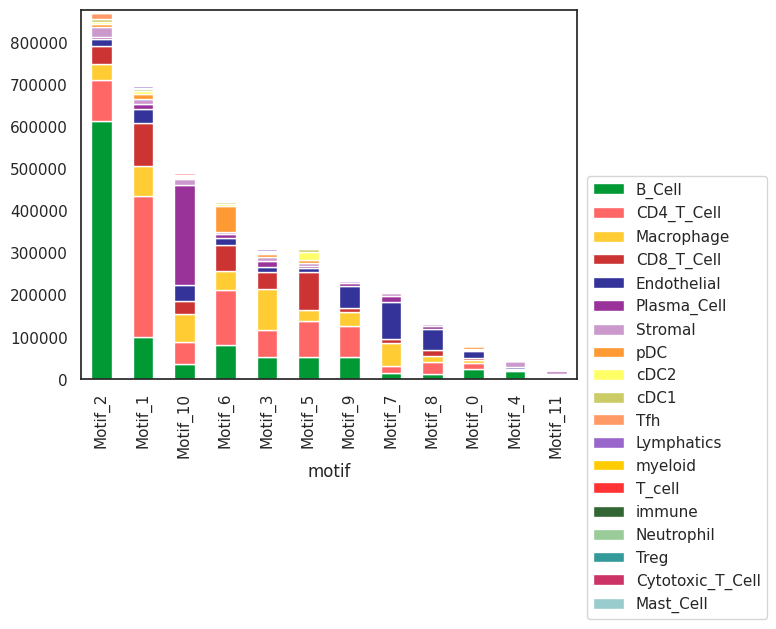

In [89]:
# fig, ax = plt.subplots(figsize=(15,15))
comp.T.plot(kind='bar', stacked=True,  colormap=cc_map)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.savefig("figures/Figure2/barplots_Motif_celltype.pdf", bbox_inches="tight")

In [90]:
pdata = adata.obs[['donor', 'motif']].pivot_table(index='motif',columns='donor', 
                                                      aggfunc=len, fill_value=0)
sort_i = pdata.apply(np.sum,axis=1).sort_values(ascending=False).index
pdata = pdata.loc[sort_i,]
pdata

donor      HVCD1   HVCD2    MCD1    MCD3    MCD4      R1     R2
motif                                                          
Motif_2   252683  234660  116966    5702   54790  196560  17302
Motif_1   237008  185411  116507   10447   18160   89943  51983
Motif_10    3022     420   21547  134380  331877     439    763
Motif_6   131201  116742  111661    1923   17569   50454   2362
Motif_3    61092   68776   56321   17967   65148   33822  16718
Motif_5    77114   58311    4456    1479   74231   97843   2962
Motif_9    43953   46399  111628   11881    7271    7140  12317
Motif_7    12753    3153   72281   70654   38245    9582   8633
Motif_8    18250   12022   58848   17458   14681   17695   2906
Motif_0     8449    7870   49139    2112    5281    7079    985
Motif_4     1120    3563   17405    3249   18230    1472    306
Motif_11     872    1649    1647    3142   13242    1472    358

In [109]:
# making colors
r_map = mpl.colormaps['Greens']
r_col = [mpl.colors.to_hex(r_map(0.5)), mpl.colors.to_hex(r_map(0.75))]
hvcd_map = mpl.colormaps['Purples']
hvcd_col = [mpl.colors.to_hex(hvcd_map(0.5)), mpl.colors.to_hex(hvcd_map(0.75))]
mcd_map = mpl.colormaps['YlOrRd']
mcd_col = [mpl.colors.to_hex(mcd_map(0.4)), mpl.colors.to_hex(mcd_map(0.6)), mpl.colors.to_hex(mcd_map(0.8))]
case_cols = hvcd_col + mcd_col + r_col
print(case_cols)
case_map = mpl.colors.ListedColormap(case_cols, name="Cases")

['#9e9ac8', '#6950a3', '#feab49', '#fc5b2e', '#d41020', '#73c476', '#228a44']


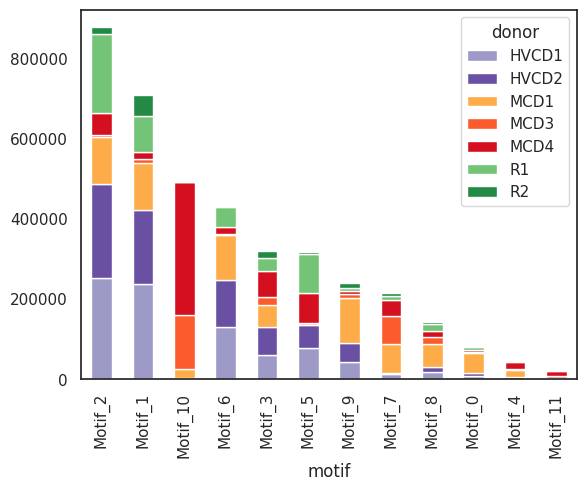

In [110]:
pdata.plot(kind='bar', stacked=True, colormap=case_map)
plt.savefig("figures/Figure2/barplots_Motif_donors.pdf", bbox_inches="tight")

## Descriptive figures

In [4]:
pdata = adata.obs.groupby(['region','new_pheno'], as_index=False).apply(len)
pdata.rename(columns={None:"Abundance"}, inplace=True)
pdata

region         new_pheno  Abundance
0    HVCD1_reg1            B_Cell      81228
1    HVCD1_reg1        CD4_T_Cell      70071
2    HVCD1_reg1        CD8_T_Cell      31867
3    HVCD1_reg1  Cytotoxic_T_Cell        307
4    HVCD1_reg1       Endothelial      11307
..          ...               ...        ...
445     R2_reg1              cDC1       1348
446     R2_reg1              cDC2       1801
447     R2_reg1            immune        128
448     R2_reg1           myeloid         68
449     R2_reg1               pDC       1345

[450 rows x 3 columns]

In [5]:
# # order pheno labels by abundance
abun_dat = adata.obs.new_pheno.value_counts().index.to_list()
pdata.new_pheno = pd.Categorical(pdata.new_pheno, categories=abun_dat, ordered=True)


/tmp/ipykernel_766698/701110851.py:10: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



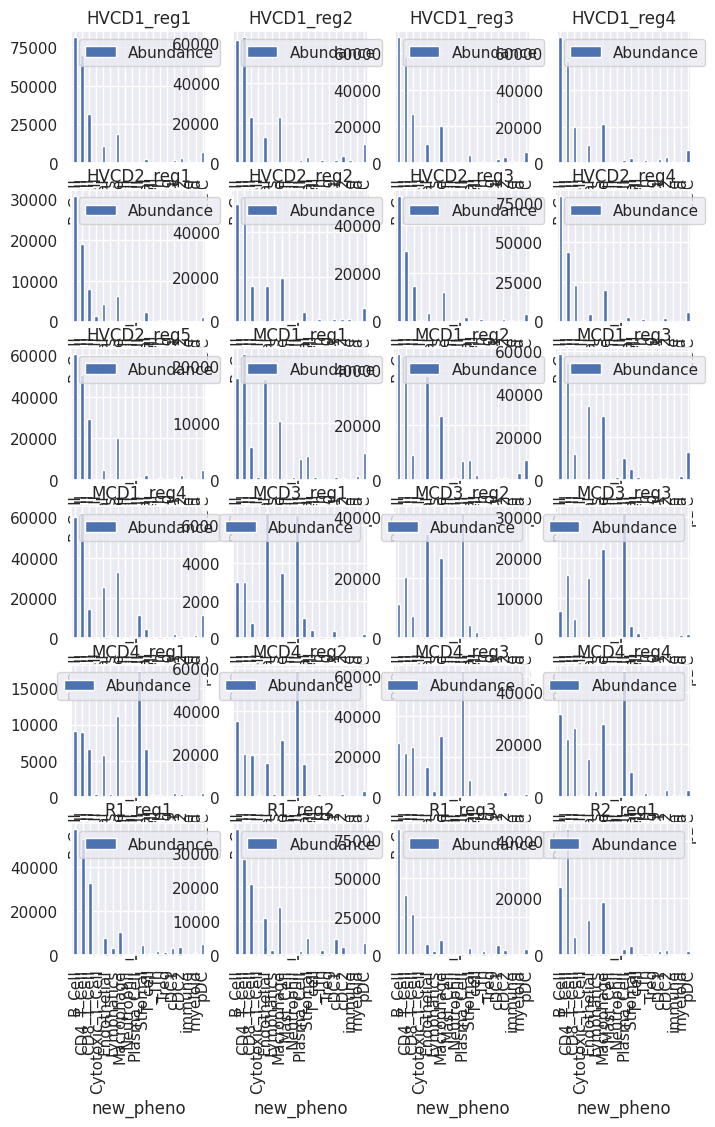

In [35]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(8,12))
ax = ax.ravel()
for i in range(pdata.region.nunique()):
    regname = pdata.region.unique()[i]
    pdata_ = pdata.loc[pdata.region==regname,:]
    # ax[i].bar(pdata_.new_pheno, pdata_.Abundance)
    pdata_.plot.bar("new_pheno", "Abundance", ax=ax[i])
    ax[i].set_title(regname)
plt.savefig("figures/barplots_celltypes_byregion.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_766698/172742334.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



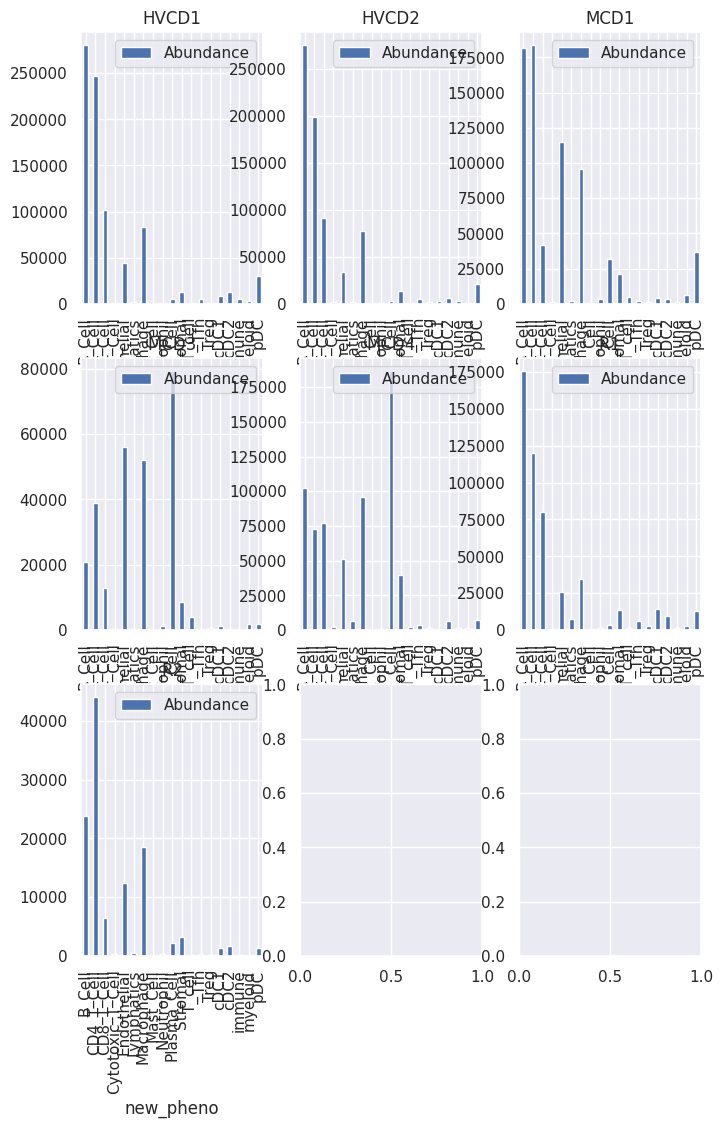

In [43]:
pdata = adata.obs.groupby(['donor','new_pheno'], as_index=False).apply(len)
pdata.rename(columns={None:"Abundance"}, inplace=True)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,12))
ax = ax.ravel()
for i in range(pdata.donor.nunique()):
    donorname = pdata.donor.unique()[i]
    pdata_ = pdata.loc[pdata.donor==donorname,:]
    # ax[i].bar(pdata_.new_pheno, pdata_.Abundance)
    pdata_.plot.bar("new_pheno", "Abundance", ax=ax[i])
    ax[i].set_title(donorname)
plt.savefig("figures/barplots_celltypes_bydonor.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_2598287/3036132494.py:18: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



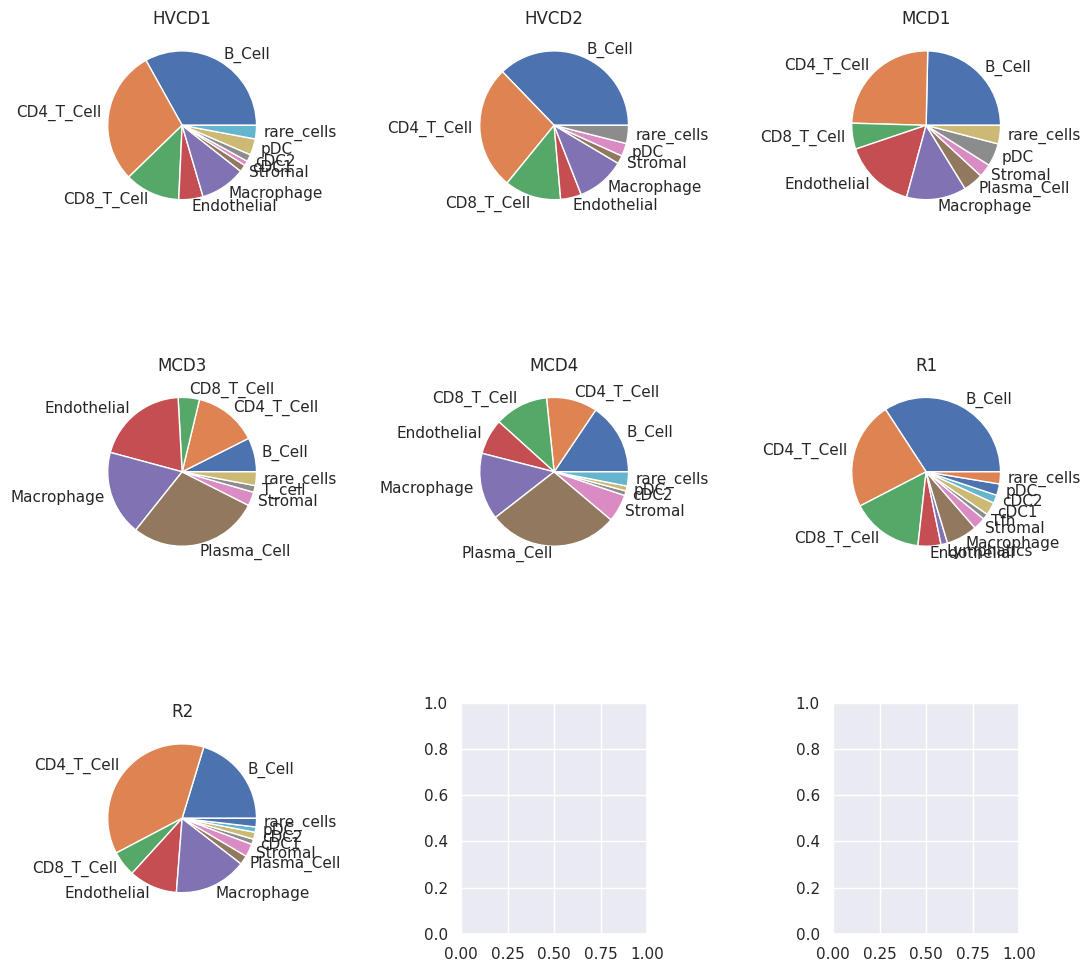

In [19]:
pdata = adata.obs.groupby(['donor','new_pheno'], as_index=False).apply(len)
pdata.rename(columns={None:"Abundance"}, inplace=True)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
ax = ax.ravel()
for i in range(pdata.donor.nunique()):
    donorname = pdata.donor.unique()[i]
    pdata_ = pdata.loc[pdata.donor==donorname,:].copy()
    pdata_.drop(['donor'], axis=1, inplace=True)
    pdata_.set_index('new_pheno', inplace=True)
    keep = pdata_.Abundance > 0.01*(adata.obs.donor == donorname).sum()
    pie_dat = pdata_.Abundance.loc[keep]
    pie_dat['rare_cells'] = pdata_[~keep].Abundance.sum()
    ax[i].pie(pie_dat, labels=pie_dat.index)
    ax[i].set_title(donorname)
plt.subplots_adjust(hspace=0.5, wspace = 1)
plt.savefig("figures/pieplots_celltypes_bydonor.pdf", bbox_inches="tight")
fig.show()

## Motifs

In [9]:
col_list = ["#990000", "#e37870", "#f63b32", "#52bcd4", "#cccc66", "#679c40", "#005487", "#1c0608", 
            "#002B52", "#f3fbfb", "#f3ff41", "#666600"]
motif_colors = {adata.obs.motif.unique().sort_values()[i]:col_list[i] for i in range(adata.obs.motif.nunique())}
# motif_colors = {adata.obs.motif.unique()[i]:col_list[i] for i in range(adata.obs.motif.nunique())}
motif_colors

{'Motif_0': '#990000',
 'Motif_1': '#e37870',
 'Motif_2': '#f63b32',
 'Motif_3': '#52bcd4',
 'Motif_4': '#cccc66',
 'Motif_5': '#679c40',
 'Motif_6': '#005487',
 'Motif_7': '#1c0608',
 'Motif_8': '#002B52',
 'Motif_9': '#f3fbfb',
 'Motif_10': '#f3ff41',
 'Motif_11': '#666600'}

### R1

In [6]:
pdata = adata.obs.loc[adata.obs.region == "R1_reg1",:]
pdata.head()

Absolute.X  Absolute.Y  Cell.Size   In.Tile.X   In.Tile.Y  Reg  \
3707743   25.738007  300.151292        543   25.738007  300.151292    0   
3707744  136.381818  642.152727        436  136.381818  642.152727    0   
3707745  201.011952  342.239044        408  201.011952  342.239044    0   
3707746  251.668919  194.625000        552  251.668919  194.625000    0   
3707747  504.993377  679.453642        511  504.993377  679.453642    0   

         Tile.Col  Tile.Row  Tile.Z  Unnamed: 0  ...    nCount_raw  \
3707743         1         1       0         1.0  ...   9999.999401   
3707744         1         1       0         2.0  ...  10000.000152   
3707745         1         1       0         3.0  ...  10000.000987   
3707746         1         1       0         4.0  ...  10000.000355   
3707747         1         1       0         5.0  ...  10000.001102   

         nFeature_originalexp  nFeature_raw n_genes_by_counts   new_pheno  \
3707743                    19            43                43  CD4_T_Cell   
3707744                    14            35                35  CD8_T_Cell   
3707745                    16            39                39  CD4_T_Cell   
3707746                    17            43                43        cDC2   
3707747                    18            35                35  CD8_T_Cell   

         obs_names     orig.ident   region  total_counts donor  
3707743  0_R1_reg1  SeuratProject  R1_reg1    420.834930    R1  
3707744  1_R1_reg1  SeuratProject  R1_reg1    268.265747    R1  
3707745  2_R1_reg1  SeuratProject  R1_reg1    454.947296    R1  
3707746  3_R1_reg1  SeuratProject  R1_reg1    444.361938    R1  
3707747  4_R1_reg1  SeuratProject  R1_reg1    256.807068    R1  

[5 rows x 25 columns]

In [10]:
print(pdata['Absolute.X'].max())
print(pdata['Absolute.Y'].max())

9972.82608695652
7478.16666666667


In [7]:
xmin = 5000
xmax = 7000
ymin = 1500
ymax = 3500
pdata_ = pdata.loc[(pdata['Absolute.X'] > xmin) & (pdata['Absolute.X'] < xmax) & (pdata['Absolute.Y'] > ymin) & (pdata['Absolute.Y'] < ymax),:]
pdata_.shape

(10267, 25)

Trying to set attribute `.obs` of view, copying.


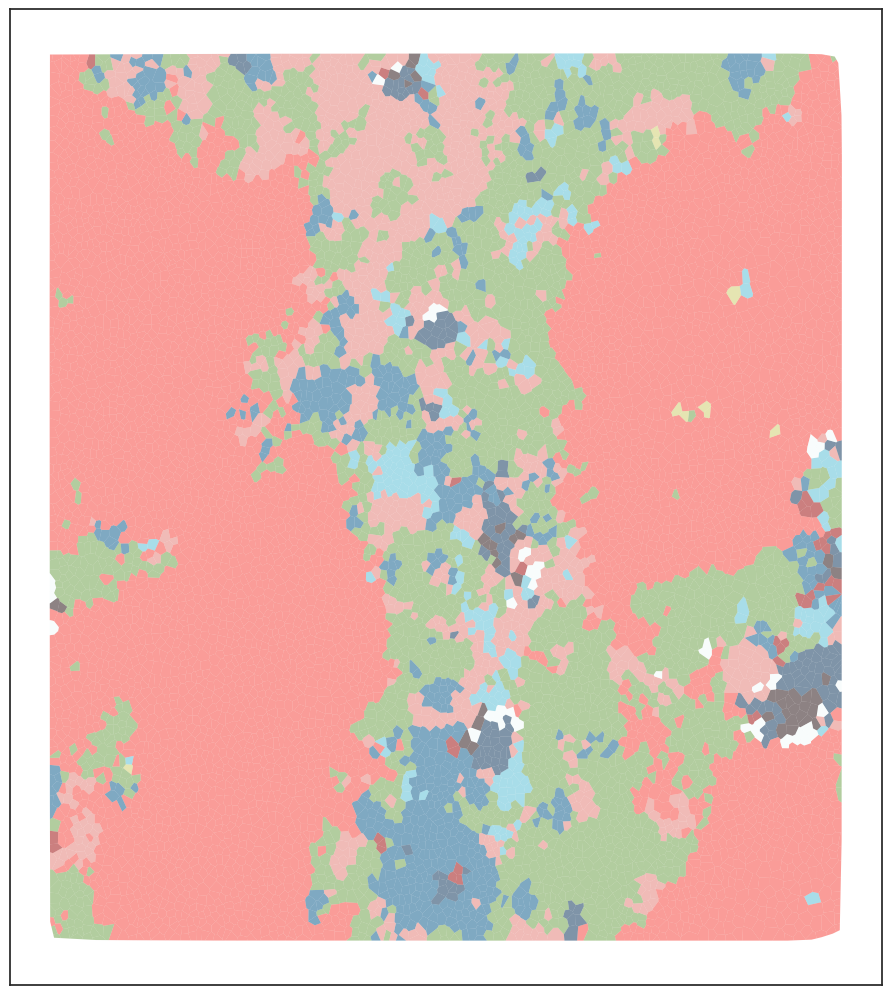

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(adata[pdata_.index,:], x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
              color_by = 'motif', colors=motif_colors, 
              imageid='orig.ident',voronoi_edge_color='white', voronoi_line_width=0, **{'ax':ax})
# plt.savefig("figures/voronoi_R1_reg1_dutch1.pdf", dpi=300)
plt.savefig("figures/Figure2/voronoi_R1_reg1_reef1.jpeg", dpi=300)

### HVCD2

In [12]:
pdata = adata.obs.loc[adata.obs.region == "HVCD2_reg3",:]
print(pdata['Absolute.X'].max())
print(pdata['Absolute.Y'].max())

10021.2916666667
7486.625


In [13]:
xmin = 3000
xmax = 5000
ymin = 5500
ymax = 7500
pdata_ = pdata.loc[(pdata['Absolute.X'] > xmin) & (pdata['Absolute.X'] < xmax) & (pdata['Absolute.Y'] > ymin) & (pdata['Absolute.Y'] < ymax),:]
pdata_.shape

(10135, 25)

Trying to set attribute `.obs` of view, copying.


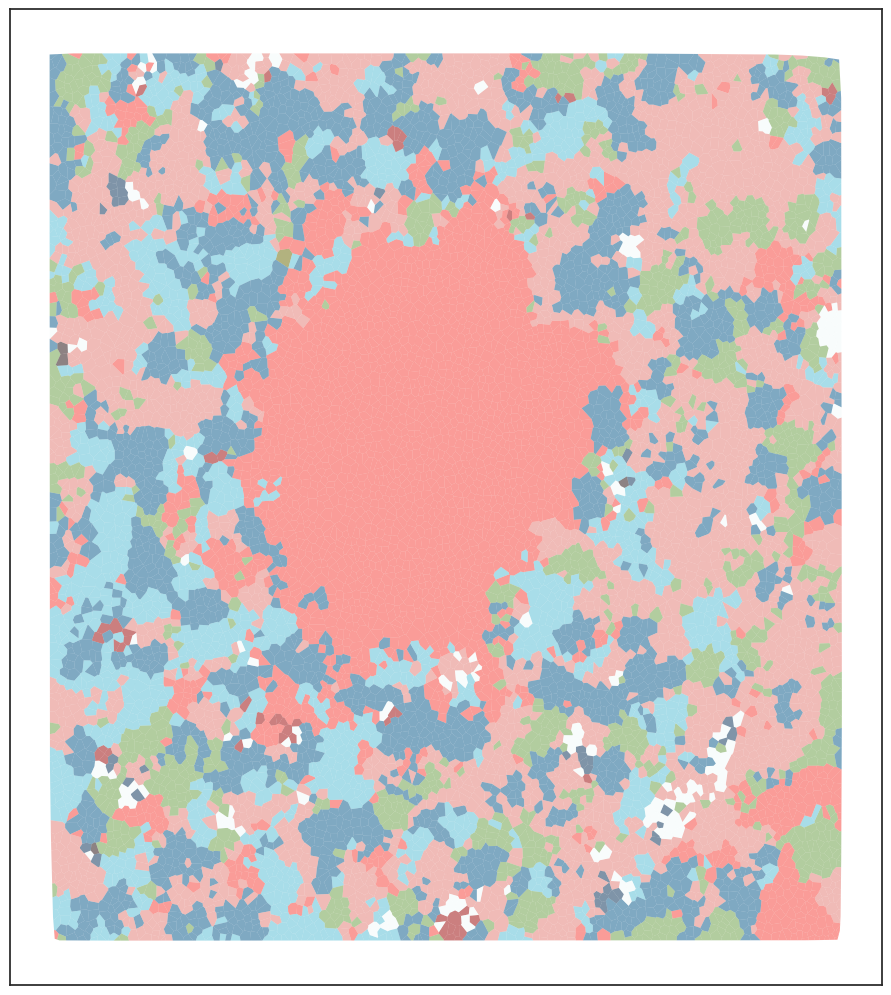

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(adata[pdata_.index,:], x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
              color_by = 'motif', colors=motif_colors, 
              imageid='orig.ident',voronoi_edge_color='white', voronoi_line_width=0, **{'ax':ax})
# plt.savefig("figures/voronoi_R1_reg1_dutch1.pdf", dpi=300)
# plt.savefig("figures/voronoi_HVCD2_reg3_dutch1.jpeg", dpi=300)
plt.savefig("figures/Figure2/voronoi_HVCD2_reg3_reef1.jpeg", dpi=300)

### MCD1

In [37]:
pdata = adata.obs.loc[adata.obs.region == "MCD1_reg1",:]
print(pdata['Absolute.X'].max())
print(pdata['Absolute.Y'].max())

7798.0
9466.4099378882


In [115]:
pdata['Absolute.Y'].sort_values()

186      2714.000000
421      2714.052817
453      2714.340659
1763     2714.487395
277      2714.723270
            ...     
80649    9465.442857
78388    9465.460870
78484    9465.500000
80495    9465.720670
78721    9466.409938
Name: Absolute.Y, Length: 90055, dtype: float64

In [38]:
xmin = 500
xmax = 2500
ymin = 2000+2700
ymax = 4000+2700
pdata_ = pdata.loc[(pdata['Absolute.X'] > xmin) & (pdata['Absolute.X'] < xmax) & (pdata['Absolute.Y'] > ymin) & (pdata['Absolute.Y'] < ymax),:]
pdata_.shape

(8943, 25)

Trying to set attribute `.obs` of view, copying.


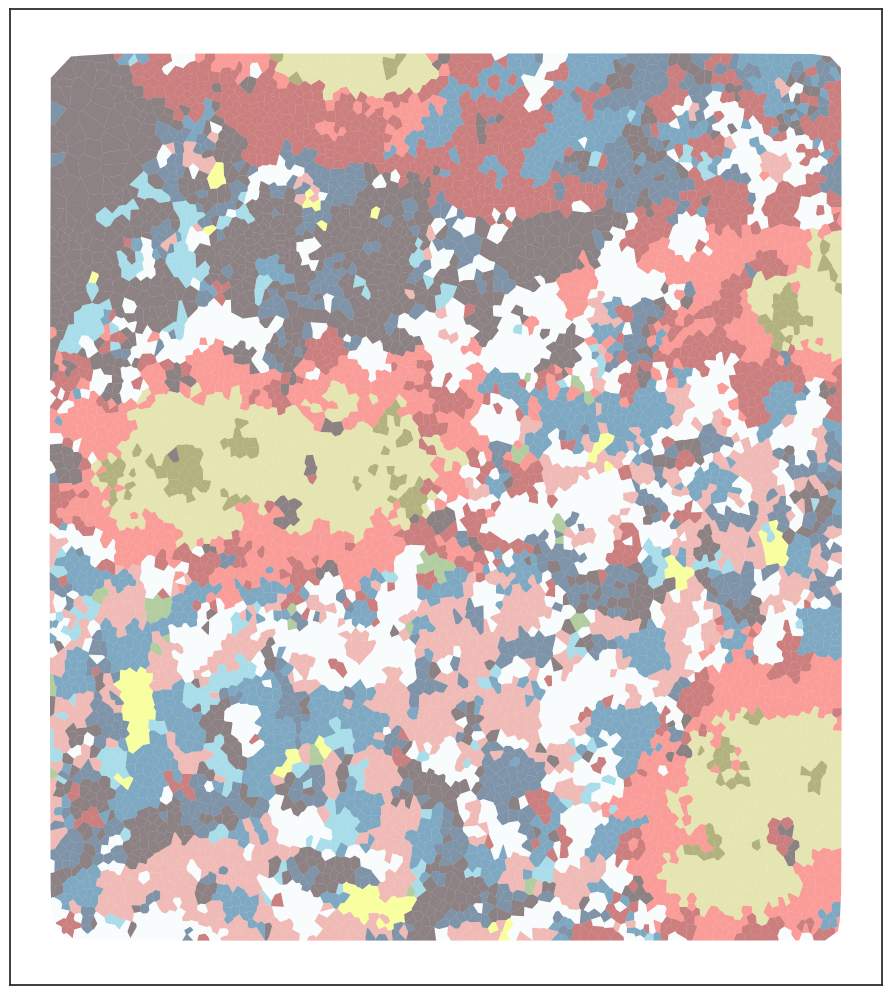

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(adata[pdata_.index,:], x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
              color_by = 'motif', colors=motif_colors, 
              imageid='orig.ident',voronoi_edge_color='white', voronoi_line_width=0, **{'ax':ax})
# plt.savefig("figures/voronoi_R1_reg1_dutch1.pdf", dpi=300)
# plt.savefig("figures/Figure2/voronoi_MCD1_reg1_dutch1.jpeg", dpi=300)
plt.savefig("figures/Figure2/voronoi_MCD1_reg1_reef1.jpeg", dpi=300)

### MCD3

In [24]:
pdata = adata.obs.loc[adata.obs.region == "MCD3_reg2",:]
print(pdata['Absolute.X'].max())
print(pdata['Absolute.Y'].max())


9996.0
9482.69565217391


In [120]:
pdata['Absolute.X'].sort_values()

90079       26.413043
98320       27.672269
110889      28.406250
124953      31.212903
164683      33.512605
             ...     
229781    9995.725806
240737    9995.800000
229476    9995.903226
240675    9995.969697
240549    9996.000000
Name: Absolute.X, Length: 150726, dtype: float64

In [25]:
xmin = 6000
xmax = 8000
ymin = 800
ymax = 2800
pdata_ = pdata.loc[(pdata['Absolute.X'] > xmin) & (pdata['Absolute.X'] < xmax) & (pdata['Absolute.Y'] > ymin) & (pdata['Absolute.Y'] < ymax),:]
pdata_.shape

(8386, 25)

Trying to set attribute `.obs` of view, copying.


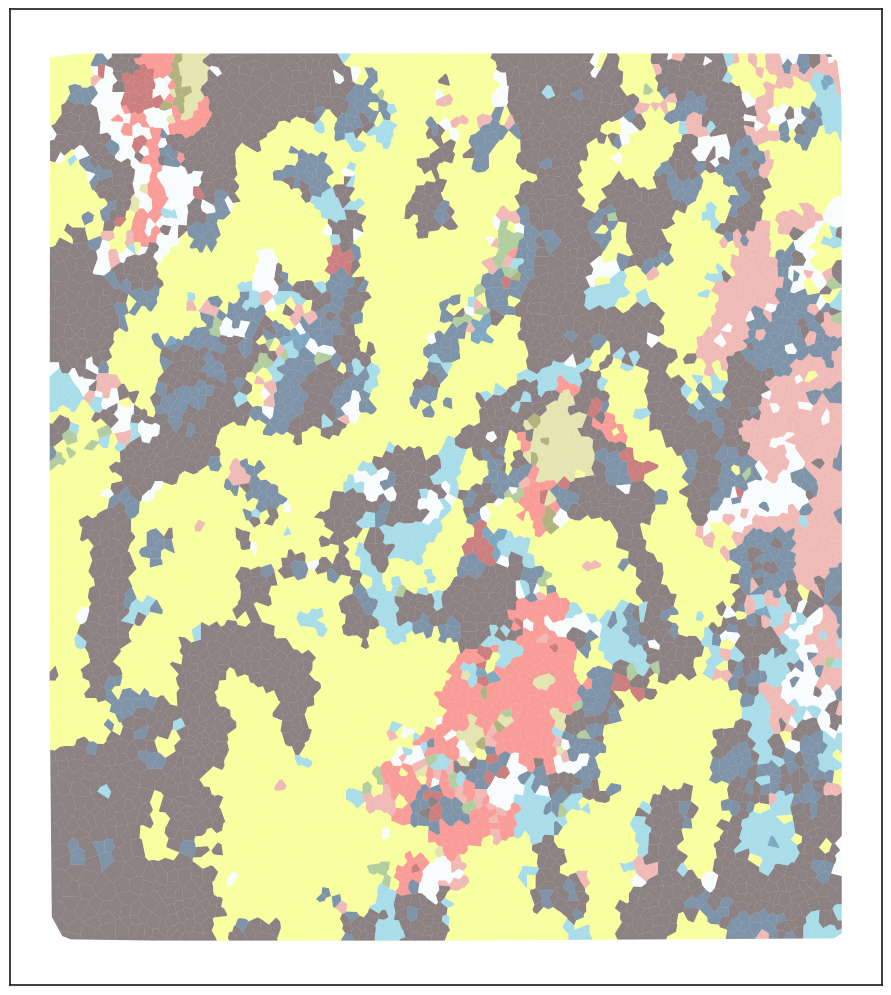

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(adata[pdata_.index,:], x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
              color_by = 'motif', colors=motif_colors, 
              imageid='orig.ident',voronoi_edge_color='white', voronoi_line_width=0, **{'ax':ax})
# plt.savefig("figures/voronoi_R1_reg1_dutch1.pdf", dpi=300)
# plt.savefig("figures/Figure2/voronoi_MCD3_reg2_dutch1.jpeg", dpi=300)
plt.savefig("figures/Figure2/voronoi_MCD3_reg2_reef1.jpeg", dpi=300)

### HVCD2 (for follicle contouring)

In [35]:
pdata = adata.obs.loc[adata.obs.region == "HVCD2_reg2",:]
print(pdata['Absolute.X'].max())
print(pdata['Absolute.Y'].max())
xmin = 2800
xmax = 8760
ymin = 0
ymax = 4200
pdata_ = pdata.loc[(pdata['Absolute.X'] > xmin) & (pdata['Absolute.X'] < xmax) & (pdata['Absolute.Y'] > ymin) & (pdata['Absolute.Y'] < ymax),:]
pdata_.shape

10004.3846153846
7486.36585365854


(56961, 25)

Trying to set attribute `.obs` of view, copying.


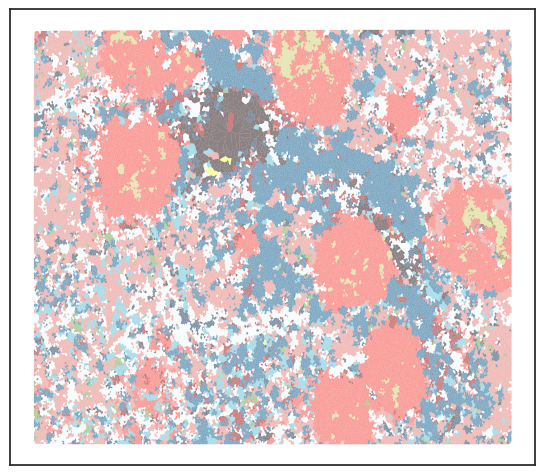

In [36]:
# fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(adata[pdata_.index,:], x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
              color_by = 'motif', colors=motif_colors, 
              imageid='orig.ident',voronoi_edge_color='white', voronoi_line_width=0)
# plt.savefig("figures/voronoi_R1_reg1_dutch1.pdf", dpi=300)
# plt.savefig("figures/Figure2/voronoi_MCD3_reg2_dutch1.jpeg", dpi=300)
plt.savefig("figures/Figure2/voronoi_HVCD2_reg2_reef1_forContours.jpeg", dpi=300)

## Cell segmentations
R1_reg3,
HVCD2_reg2,
MCD1_reg1

In [7]:
with open("../../Data/CellSeg/output/visual_output/R1_reg3_inputgrowth5mask.pckl", "rb") as f:
    pred = pk.load(f)

In [9]:
pred

array([[     0,      0,      0, ...,  20322,  20322,  20322],
       [     0,      0,      0, ...,  20322,  20322,  20322],
       [     0,      0,      0, ...,  20322,  20322,  20322],
       ...,
       [     0,      0,      0, ..., 192611, 192611, 192611],
       [     0,      0,      0, ..., 192611, 192611, 192611],
       [     0,      0,      0, ..., 192611, 192611,      0]])

## Motif cell-cell interactions

The interfollicular spaces of interest are:
Motif_1 -- CD4 enriched
Motif_3 -- Macrophage enriched
Motif_5 -- cDC enriched
Motif_7 -- endo enriched
Motif_6 -- pDC enriched

In [10]:
adata.obs['disease'] = adata.obs.donor.map(lambda x: re.search('\D*',x).group(0))
# adata.obs.donor.iloc[0:10].map(lambda x: re.search('\D*',x).group(0))

In [7]:
out_path = "figures/Figure2/interfollicular"

In [7]:
adata.obs.columns

Index(['Absolute.X', 'Absolute.Y', 'Cell.Size', 'In.Tile.X', 'In.Tile.Y',
       'Reg', 'Tile.Col', 'Tile.Row', 'Tile.Z', 'Unnamed: 0',
       'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'index_info', 'motif',
       'nCount_originalexp', 'nCount_raw', 'nFeature_originalexp',
       'nFeature_raw', 'n_genes_by_counts', 'new_pheno', 'obs_names',
       'orig.ident', 'region', 'total_counts', 'donor'],
      dtype='object')

In [11]:
interfoll_motif = ['Motif_1', 'Motif_3', 'Motif_5', 'Motif_7', 'Motif_6']
all_interfoll = ['Motif_1', 'Motif_3', 'Motif_5', 'Motif_7', 'Motif_6', 'Motif_10', 'Motif_9']

In [15]:
d = "HVCD"
c = "Motif_1"
d_adata = adata[(adata.obs['disease'] == d) & (adata.obs['motif'].isin(interfoll_motif)), :].copy()
c_adata = d_adata[d_adata.obs['motif'] == c, :].copy()


Processing Image: ['HVCD2_reg1']
Categories (1, object): ['HVCD2_reg1']
Identifying the 5 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 500 permutations
Consolidating the permutation results
Processing Image: ['HVCD1_reg3']
Categories (1, object): ['HVCD1_reg3']
Identifying the 5 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 500 permutations
Consolidating the permutation results
Processing Image: ['HVCD2_reg3']
Categories (1, object): ['HVCD2_reg3']
Identifying the 5 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 500 permutations
Consolidating the permutation results
Processing Image: ['HVCD1_reg1']
Categories (1, object): ['HVCD1_reg1']
Identifying the 5 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 500 permutations
Consolidating the permutation results
Processing Image: ['HVCD2_reg2']
Categories (1, object): ['HVCD2_reg2']
Identifying the 5 nearest neighbours for eve

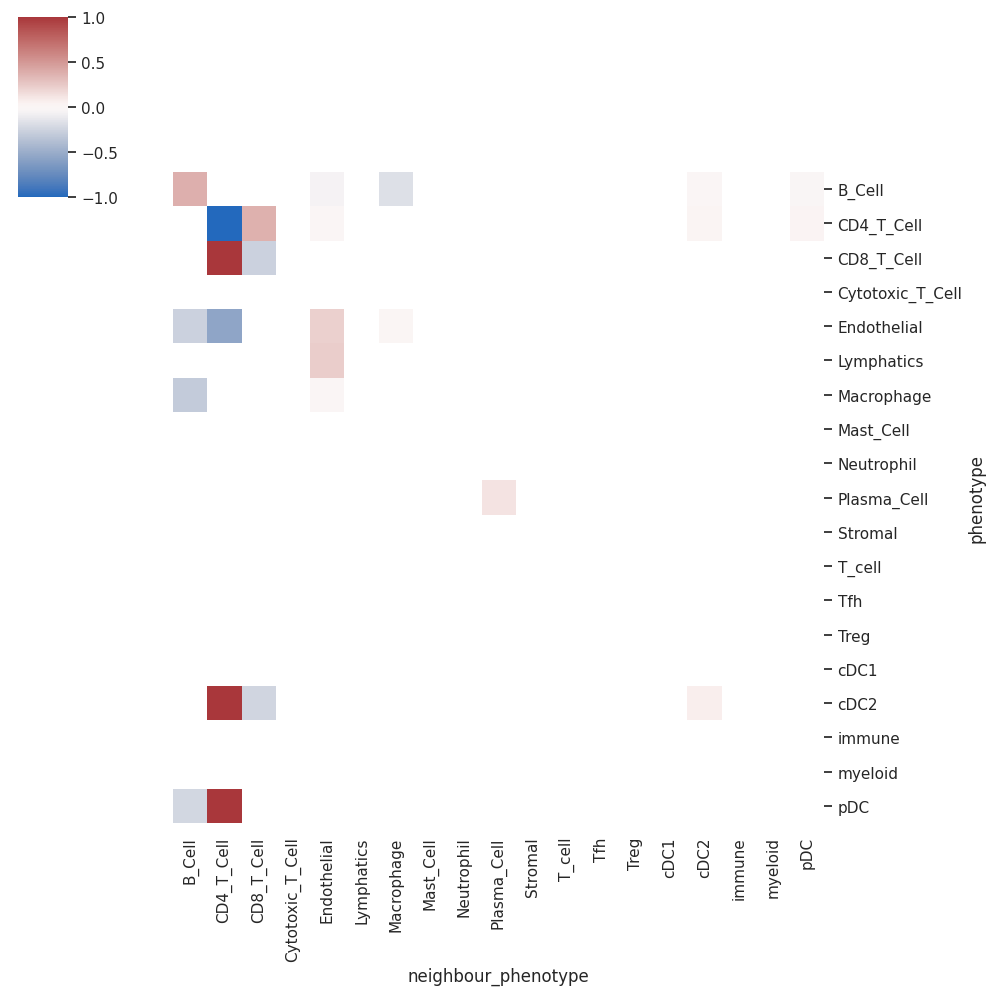

In [18]:
c_adata = sm.tl.spatial_interaction(c_adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                                   phenotype='new_pheno', imageid='region',
                                  method='knn', knn=5, permutation=500)
sm.pl.spatial_interaction(c_adata)

In [8]:
# by sample
for d in adata.obs['donor'].unique():
    if not os.path.isdir(os.path.join(out_path, d)):
        os.mkdir(os.path.join(out_path, d))
    d_adata = adata[(adata.obs['donor'] == d) & (adata.obs['motif'].isin(all_interfoll)), :].copy()
    if not os.path.isfile(os.path.join(out_path, d, 'interfollicle_all_foll_intxn_heatmap.pdf')):
        d_adata = sm.tl.spatial_interaction(d_adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                                   phenotype='new_pheno', imageid='region',
                                  method='radius', radius=60)
        sm.pl.spatial_interaction(d_adata)
        plt.savefig(os.path.join(out_path, d, 'interfollicle_all_foll_r60_intxn_heatmap.pdf'))
        plt.close()

Processing Image: ['MCD1_reg1']
Categories (1, object): ['MCD1_reg1']
Identifying neighbours within 60 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['MCD1_reg3']
Categories (1, object): ['MCD1_reg3']
Identifying neighbours within 60 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['MCD1_reg4']
Categories (1, object): ['MCD1_reg4']
Identifying neighbours within 60 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['MCD1_reg2']
Categories (1, object): ['MCD1_reg2']
Identifying neighbours within 60 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['MCD3_reg2']
Categories (1, object): ['MCD3_reg2']
Identifying neighbours within 60 pixels of

In [16]:
# by disease
for d in adata.obs['disease'].unique():
    d_adata = adata[(adata.obs['disease'] == d) & (adata.obs['motif'].isin(all_interfoll)), :].copy()
    
    # d_adata = sm.tl.spatial_distance(d_adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
    #                                phenotype='new_pheno', imageid='region')
    # sm.pl.spatial_distance(d_adata, phenotype='new_pheno', heatmap_standard_scale=1)
    # plt.savefig(os.path.join(out_path, d, 'interfollicle_dist_heatmap.pdf'))
    # plt.close()
    if not os.path.isfile(os.path.join(out_path, d, 'interfollicle_all_foll_intxn_heatmap.pdf')):
        d_adata = sm.tl.spatial_interaction(d_adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
                                   phenotype='new_pheno', imageid='region',
                                  method='radius', radius=60)
        sm.pl.spatial_interaction(d_adata)
        plt.savefig(os.path.join(out_path, d, 'interfollicle_all_foll_r60_intxn_heatmap.pdf'))
        plt.close()
    
    # for c in interfoll_motif:
    #     c_adata = d_adata[d_adata.obs['motif'] == c, :].copy()
    #     # c_adata = sm.tl.spatial_distance(c_adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
    #     #                            phenotype='new_pheno', imageid='region')
    #     # sm.pl.spatial_distance(c_adata, phenotype='new_pheno', heatmap_standard_scale=1)
    #     # plt.savefig(os.path.join(out_path, d, c + '_dist_heatmap.pdf'))
    #     # plt.close()
    #     c_adata = sm.tl.spatial_interaction(c_adata, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
    #                                phenotype='new_pheno', imageid='region',
    #                               method='knn', knn=5)
    #     sm.pl.spatial_interaction(c_adata)
    #     plt.savefig(os.path.join(out_path, d, c + 'k5_intxn_heatmap.pdf'))
    #     plt.close()

Processing Image: ['MCD1_reg1']
Categories (1, object): ['MCD1_reg1']
Identifying neighbours within 60 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['MCD3_reg2']
Categories (1, object): ['MCD3_reg2']
Identifying neighbours within 60 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['MCD1_reg3']
Categories (1, object): ['MCD1_reg3']
Identifying neighbours within 60 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['MCD4_reg3']
Categories (1, object): ['MCD4_reg3']
Identifying neighbours within 60 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['MCD3_reg1']
Categories (1, object): ['MCD3_reg1']
Identifying neighbours within 60 pixels of

#### Cell-cell interaction figures

In [5]:
def single_csr(V, p, r):
    density = p/V
    probs = 2*(density*math.pi)*(r**2)*math.exp(-density*(r**2))
    return probs
make_csr = np.vectorize(single_csr)

In [6]:
def simulate_positions(ad, c1, c2):
    dat = ad[ad.obs['new_pheno'].isin([c1,c2]),:].copy()
    ymin = np.floor(dat.obs['Absolute.Y'].min()).astype(int)
    ymax = np.floor(dat.obs['Absolute.Y'].max()).astype(int)
    xmin = np.floor(dat.obs['Absolute.X'].min()).astype(int)
    xmax = np.floor(dat.obs['Absolute.X'].max()).astype(int)
    dat.obs['Absolute.Y'] = random.choices(range(ymin, ymax), k=dat.shape[0])
    dat.obs['Absolute.X'] = random.choices(range(xmin, xmax), k=dat.shape[0])
    return dat

In [7]:
def cc_dist(ad, c1, c2):
    ref_dat = ad.obs.loc[ad.obs['new_pheno']==c1, ['Absolute.Y', 'Absolute.X']]
    q_dat = ad.obs.loc[ad.obs['new_pheno']==c2, ['Absolute.Y', 'Absolute.X']]
    ref_tree = sci.spatial.cKDTree(ref_dat)
    dist_res = ref_tree.query(q_dat, k=1)
    ecdf = ECDF(dist_res[0])
    return(ecdf)

In [8]:
# making the CSR
def simdata(adata, ref_dat, q_dat, ecdf):
    y = np.ptp(adata.obs['Absolute.Y'])
    x = np.ptp(adata.obs['Absolute.X'])
    area = y*x
    events = ref_dat.shape[0] + q_dat.shape[0]
    dist = np.arange(1,np.floor(ecdf.x.max()), 5)
    csr_prob = make_csr(area, events, dist)
    csr_prob = csr_prob/csr_prob.sum()
    csr_cdf = np.array(list(map(lambda x: csr_prob[0:x].sum(), np.arange(len(dist)))))
    return (dist, csr_cdf)

In [9]:
# cell-cell distances
def runCCtest(case_dat, motif_name):
    itxn_dir = os.path.join('figures','Figure2','interfollicular','distance_distributions',motif_name)
    if not os.path.isdir(itxn_dir):
            os.mkdir(itxn_dir)
            
    cc_itxn_dict = {}
    top_cells = case_dat.obs.new_pheno.value_counts().sort_values(ascending=False).index[0:10].values
    for c in tqdm.tqdm(top_cells):
        if not os.path.isdir(os.path.join(itxn_dir,c)):
            os.mkdir(os.path.join(itxn_dir,c))
        for cc in case_dat.obs['new_pheno'].unique():
            if c == cc:
                continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'R', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='R', 'new_pheno']==cc) < 100: 
                continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'MCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='MCD', 'new_pheno']==cc) < 100: 
                continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'HVCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='HVCD', 'new_pheno']==cc) < 100: 
                continue
            # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.png')): # in case of a failed run
            #     continue
            c_key = c + ' -- ' + cc
            cc_itxn_dict[c_key] = []
            dis_dict = {}
            dist = None
            for cname in case_dat.obs.disease.unique():
                dat_dict = []
                for r in case_dat.obs.loc[case_dat.obs['disease']==cname, 'region'].unique():
                    adata_sub = case_dat[case_dat.obs.region == r,:].copy()
                    ref_dat = adata_sub.obs.loc[adata_sub.obs['new_pheno']==c, ['Absolute.Y', 'Absolute.X']]
                    q_dat = adata_sub.obs.loc[adata_sub.obs['new_pheno']==cc, ['Absolute.Y', 'Absolute.X']]
                    ref_tree = sci.spatial.cKDTree(ref_dat)
                    dist_res = ref_tree.query(q_dat, k=1)
                    ecdf = ECDF(dist_res[0])
                    if dist is None: # just going to take the first region we get
                        dist = np.arange(1,np.floor(ecdf.x.max()), 1) # what should the distance be? dist = np.arange(1,np.floor(ecdf.x.max()), 5) of R?
                        dis_dict['dist'] = pd.Series(dist)
                    dat_dict.append(pd.Series(ecdf(dist)))
                merge_df = pd.concat(dat_dict, axis=1)
                # for r, df in dat_dict.items():
                #     if merge_df is None:
                #         merge_df = dat_dict[r]
                #     else:
                #         merge_df = merge_df.join(df)
                dis_dict[cname] = merge_df.apply(np.mean, axis=1)
            dis_merge_df = pd.DataFrame(dis_dict)
            cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['R']-0.5))])
            cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['MCD']-0.5))])
            cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['HVCD']-0.5))])
            stat = sci.stats.ks_2samp(dis_merge_df['R'], dis_merge_df['MCD'])
            cc_itxn_dict[c_key].append(stat[1])
            stat = sci.stats.ks_2samp(dis_merge_df['R'], dis_merge_df['HVCD'])
            cc_itxn_dict[c_key].append(stat[1])

            rplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['R'])
            mcdplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD'], c='red')
            hvcdplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['HVCD'], c='green')
            plt.legend([rplot, mcdplot, hvcdplot], ['R', 'MCD', 'HVCD'], loc = 'lower right')
            plt.savefig(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf'))
            plt.close()
    cc_df = pd.DataFrame(cc_itxn_dict).T
    cc_df.columns = ['avg_R_distance', 'avg_MCD_distance', 'avg_HVCD_distance', 'p_val_MCD', 'p_val_HVCD']
    cc_df['p_val_adj'] = multipletests(cc_df['p_val'], method='bonferroni')[1]
    cc_df.to_csv(os.path.join(itxn_dir, "stats.csv"))
    return None


In [15]:
test_dat = adata[adata.obs.region != "R2_reg1", :].copy()
# for m in interfoll_motif:
for m in test_dat.obs['motif'].unique():
    if os.path.isdir(os.path.join('figures','Figure2','interfollicular','distance_distributions',m)):
        continue
    else:
        os.mkdir(os.path.join('figures','Figure2','interfollicular','distance_distributions',m))
    itxn_dir = os.path.join('figures','Figure2','interfollicular','distance_distributions',m,'dist_200')
    if not os.path.isdir(itxn_dir):
        os.mkdir(itxn_dir)
    case_dat = test_dat[test_dat.obs['motif'] == m, :].copy()
            
    cc_itxn_dict = {}
    top_cells = case_dat.obs.new_pheno.value_counts().sort_values(ascending=False).index[0:10].values
    for c in tqdm.tqdm(top_cells):
        if not os.path.isdir(os.path.join(itxn_dir,c)):
            os.mkdir(os.path.join(itxn_dir,c))
        for cc in case_dat.obs['new_pheno'].unique():
            skip_token=0
            if c == cc:
                continue
            # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf')):
            #     continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'R', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='R', 'new_pheno']==cc) < 100: 
                continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'MCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='MCD', 'new_pheno']==cc) < 100: 
                continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'HVCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='HVCD', 'new_pheno']==cc) < 100: 
                continue
            # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.png')): # in case of a failed run
            #     continue
            c_key = c + ' -- ' + cc
            dis_dict = {}
            dist = None
            for cname in case_dat.obs.disease.unique():
                dat_dict = []
                for r in case_dat.obs.loc[case_dat.obs['disease']==cname, 'region'].unique():
                    adata_sub = case_dat.obs.loc[case_dat.obs.region == r,:].copy()
                    ref_dat = adata_sub.loc[adata_sub['new_pheno']==c, ['Absolute.Y', 'Absolute.X']]
                    q_dat = adata_sub.loc[adata_sub['new_pheno']==cc, ['Absolute.Y', 'Absolute.X']]
                    if ref_dat.shape[0] < 100 or q_dat.shape[0] < 100:
                        continue
                    ref_tree = sci.spatial.cKDTree(ref_dat)
                    dist_res = ref_tree.query(q_dat, k=1)
                    ecdf = ECDF(dist_res[0])
                    if dist is None: # just going to take the first region we get
                        # dist = np.arange(1,np.floor(ecdf.x.max()), 1) # what should the distance be? dist = np.arange(1,np.floor(ecdf.x.max()), 5) of R?
                        dist = np.arange(1,200,1)
                        dis_dict['dist'] = pd.Series(dist)
                    dat_dict.append(pd.Series(ecdf(dist)))
                if len(dat_dict) == 0:
                    skip_token = 1
                    break
                merge_df = pd.concat(dat_dict, axis=1)
                dis_dict[cname] = merge_df.apply(np.mean, axis=1)
            if skip_token==1:
                continue
            cc_itxn_dict[c_key] = []
            dis_merge_df = pd.DataFrame(dis_dict)
            cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['R']-0.5))])
            cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['MCD']-0.5))])
            cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['HVCD']-0.5))])
            stat = sci.stats.ks_2samp(dis_merge_df['R'], dis_merge_df['MCD'])
            cc_itxn_dict[c_key].append(stat[1])
            stat = sci.stats.ks_2samp(dis_merge_df['R'], dis_merge_df['HVCD'])
            cc_itxn_dict[c_key].append(stat[1])

            rplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['R'])
            mcdplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD'], c='red')
            hvcdplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['HVCD'], c='green')
            plt.legend([rplot, mcdplot, hvcdplot], ['R', 'MCD', 'HVCD'], loc = 'lower right')
            plt.savefig(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf'))
            plt.close()
    cc_df = pd.DataFrame(cc_itxn_dict).T
    if len(cc_df) == 0:
        continue
    cc_df.columns = ['avg_R_distance', 'avg_MCD_distance', 'avg_HVCD_distance', 'p_val_MCD', 'p_val_HVCD']
    cc_df['p_val_MCD_adj'] = multipletests(cc_df['p_val_MCD'], method='bonferroni')[1]
    cc_df['p_val_HVCD_adj'] = multipletests(cc_df['p_val_HVCD'], method='bonferroni')[1]
    cc_df.to_csv(os.path.join(itxn_dir, "stats.csv"))

In [15]:
# C-C interaction for all interfollicular space
test_dat = adata[adata.obs.region != "R2_reg1", :].copy()
case_dat = test_dat[test_dat.obs['motif'].isin(all_interfoll), :].copy()
itxn_dir = os.path.join('figures','Figure2','interfollicular','distance_distributions','all_interfoll','dist_200')
if not os.path.isdir(itxn_dir):
    os.mkdir(itxn_dir)
        
cc_itxn_dict = {}
top_cells = case_dat.obs.new_pheno.value_counts().sort_values(ascending=False).index[0:10].values
for c in tqdm.tqdm(top_cells):
    if not os.path.isdir(os.path.join(itxn_dir,c)):
        os.mkdir(os.path.join(itxn_dir,c))
    for cc in case_dat.obs['new_pheno'].unique():
        skip_token=0
        if c == cc:
            continue
        # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf')):
        #     continue
        if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'R', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='R', 'new_pheno']==cc) < 100: 
            continue
        if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'MCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='MCD', 'new_pheno']==cc) < 100: 
            continue
        if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'HVCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='HVCD', 'new_pheno']==cc) < 100: 
            continue
        # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.png')): # in case of a failed run
        #     continue
        c_key = c + ' -- ' + cc
        dis_dict = {}
        dist = None
        for cname in case_dat.obs.disease.unique():
            dat_dict = []
            for r in case_dat.obs.loc[case_dat.obs['disease']==cname, 'region'].unique():
                adata_sub = case_dat.obs.loc[case_dat.obs.region == r,:].copy()
                ref_dat = adata_sub.loc[adata_sub['new_pheno']==c, ['Absolute.Y', 'Absolute.X']]
                q_dat = adata_sub.loc[adata_sub['new_pheno']==cc, ['Absolute.Y', 'Absolute.X']]
                if ref_dat.shape[0] < 100 or q_dat.shape[0] < 100:
                    continue
                ref_tree = sci.spatial.cKDTree(ref_dat)
                dist_res = ref_tree.query(q_dat, k=1)
                ecdf = ECDF(dist_res[0])
                if dist is None: # just going to take the first region we get
                    # dist = np.arange(1,np.floor(ecdf.x.max()), 1) # what should the distance be? dist = np.arange(1,np.floor(ecdf.x.max()), 5) of R?
                    dist = np.arange(1,200,1)
                    dis_dict['dist'] = pd.Series(dist)
                dat_dict.append(pd.Series(ecdf(dist)))
            if len(dat_dict) == 0:
                skip_token = 1
                break
            merge_df = pd.concat(dat_dict, axis=1)
            dis_dict[cname] = merge_df.apply(np.mean, axis=1)
        if skip_token==1:
            continue
        cc_itxn_dict[c_key] = []
        dis_merge_df = pd.DataFrame(dis_dict)
        cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['R']-0.5))])
        cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['MCD']-0.5))])
        cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['HVCD']-0.5))])
        stat = sci.stats.ks_2samp(dis_merge_df['R'], dis_merge_df['MCD'])
        cc_itxn_dict[c_key].append(stat[1])
        stat = sci.stats.ks_2samp(dis_merge_df['R'], dis_merge_df['HVCD'])
        cc_itxn_dict[c_key].append(stat[1])

        rplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['R'])
        mcdplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD'], c='red')
        hvcdplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['HVCD'], c='green')
        plt.legend([rplot, mcdplot, hvcdplot], ['R', 'MCD', 'HVCD'], loc = 'lower right')
        plt.savefig(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf'))
        plt.close()
cc_df = pd.DataFrame(cc_itxn_dict).T
cc_df.columns = ['avg_R_distance', 'avg_MCD_distance', 'avg_HVCD_distance', 'p_val_MCD', 'p_val_HVCD']
cc_df['p_val_MCD_adj'] = multipletests(cc_df['p_val_MCD'], method='bonferroni')[1]
cc_df['p_val_HVCD_adj'] = multipletests(cc_df['p_val_HVCD'], method='bonferroni')[1]
cc_df.to_csv(os.path.join(itxn_dir, "stats.csv"))

100%|██████████| 10/10 [06:02<00:00, 36.29s/it]


In [12]:
# By sample, C-C interaction for all interfollicular space
test_dat = adata[adata.obs.region != "R2_reg1", :].copy()
case_dat = test_dat[test_dat.obs['motif'].isin(all_interfoll), :].copy()
itxn_dir = os.path.join('figures','Figure2','interfollicular','distance_distributions','all_interfoll_bySample','dist_200')
if not os.path.isdir(itxn_dir):
    os.mkdir(itxn_dir)
        
cc_itxn_dict = {}
top_cells = case_dat.obs.new_pheno.value_counts().sort_values(ascending=False).index[0:10].values
for c in tqdm.tqdm(top_cells):
    if not os.path.isdir(os.path.join(itxn_dir,c)):
        os.mkdir(os.path.join(itxn_dir,c))
    for cc in case_dat.obs['new_pheno'].unique():
        skip_token=0
        if c == cc:
            continue
        # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf')):
        #     continue
        if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'R', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='R', 'new_pheno']==cc) < 100: 
            continue
        if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'MCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='MCD', 'new_pheno']==cc) < 100: 
            continue
        if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'HVCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='HVCD', 'new_pheno']==cc) < 100: 
            continue
        # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.png')): # in case of a failed run
        #     continue
        c_key = c + ' -- ' + cc
        dis_dict = {}
        dist = None
        for cname in case_dat.obs.donor.unique():
            dat_dict = []
            for r in case_dat.obs.loc[case_dat.obs['donor']==cname, 'region'].unique():
                adata_sub = case_dat.obs.loc[case_dat.obs.region == r,:].copy()
                ref_dat = adata_sub.loc[adata_sub['new_pheno']==c, ['Absolute.Y', 'Absolute.X']]
                q_dat = adata_sub.loc[adata_sub['new_pheno']==cc, ['Absolute.Y', 'Absolute.X']]
                if ref_dat.shape[0] < 100 or q_dat.shape[0] < 100:
                    continue
                ref_tree = sci.spatial.cKDTree(ref_dat)
                dist_res = ref_tree.query(q_dat, k=1)
                ecdf = ECDF(dist_res[0])
                if dist is None: # just going to take the first region we get
                    # dist = np.arange(1,np.floor(ecdf.x.max()), 1) # what should the distance be? dist = np.arange(1,np.floor(ecdf.x.max()), 5) of R?
                    dist = np.arange(1,200,1)
                    dis_dict['dist'] = pd.Series(dist)
                dat_dict.append(pd.Series(ecdf(dist)))
            if len(dat_dict) == 0:
                skip_token = 1
                break
            merge_df = pd.concat(dat_dict, axis=1)
            dis_dict[cname] = merge_df.apply(np.mean, axis=1)
        if skip_token==1:
            continue
        cc_itxn_dict[c_key] = []
        dis_merge_df = pd.DataFrame(dis_dict)
        # cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['R']-0.5))])
        # cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['MCD']-0.5))])
        # cc_itxn_dict[c_key].append(dis_merge_df['dist'][np.argmin(np.absolute(dis_merge_df['HVCD']-0.5))])
        # stat = sci.stats.ks_2samp(dis_merge_df['R'], dis_merge_df['MCD'])
        # cc_itxn_dict[c_key].append(stat[1])
        # stat = sci.stats.ks_2samp(dis_merge_df['R'], dis_merge_df['HVCD'])
        # cc_itxn_dict[c_key].append(stat[1])

        rplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['R1'], '--', c='#60A9C3')
        mcd1plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD1'], '--',c='#FBB14B')
        mcd3plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD3'], '--',c='#F15C34')
        mcd4plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD4'], '--',c='#D42027')
        hvcd1plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['HVCD1'], '--',c='#C197C6')
        hvcd2plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['HVCD2'], '--',c='#854C74')
        plt.legend([rplot, mcd1plot,mcd3plot,mcd4plot, hvcd1plot,hvcd2plot], ['R', 'MCD1','MCD3','MCD4', 'HVCD1','HVCD2'], loc = 'lower right')
        plt.savefig(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf'))
        plt.close()
# cc_df = pd.DataFrame(cc_itxn_dict).T
# cc_df.columns = ['avg_R_distance', 'avg_MCD_distance', 'avg_HVCD_distance', 'p_val_MCD', 'p_val_HVCD']
# cc_df['p_val_MCD_adj'] = multipletests(cc_df['p_val_MCD'], method='bonferroni')[1]
# cc_df['p_val_HVCD_adj'] = multipletests(cc_df['p_val_HVCD'], method='bonferroni')[1]
# cc_df.to_csv(os.path.join(itxn_dir, "stats.csv"))

100%|██████████| 10/10 [07:00<00:00, 42.08s/it]


In [13]:
# Same as above but for motifs. By sample, C-C interaction
# test_dat = adata[adata.obs.region != "R2_reg1", :].copy()
# case_dat = test_dat[test_dat.obs['motif'].isin(all_interfoll), :].copy()
root_dir = os.path.join('figures','Figure2','interfollicular','distance_distributions','bySample')
# if not os.path.isdir(itxn_dir):
#     os.mkdir(itxn_dir)
        
cc_itxn_dict = {}
for m in test_dat.obs['motif'].unique():
    if os.path.isdir(os.path.join(root_dir,m)):
        continue
    else:
        os.mkdir(os.path.join(root_dir,m))
    itxn_dir = os.path.join(root_dir,m)
    if not os.path.isdir(itxn_dir):
        os.mkdir(itxn_dir)
    case_dat = test_dat[test_dat.obs['motif'] == m, :].copy()
            
    cc_itxn_dict = {}
    top_cells = case_dat.obs.new_pheno.value_counts().sort_values(ascending=False).index[0:10].values
    for c in tqdm.tqdm(top_cells):
        if not os.path.isdir(os.path.join(itxn_dir,c)):
            os.mkdir(os.path.join(itxn_dir,c))
        for cc in case_dat.obs['new_pheno'].unique():
            skip_token=0
            if c == cc:
                continue
            # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf')):
            #     continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'R', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='R', 'new_pheno']==cc) < 100: 
                continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'MCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='MCD', 'new_pheno']==cc) < 100: 
                continue
            if np.sum(case_dat.obs.loc[case_dat.obs.disease == 'HVCD', 'new_pheno']==c) < 100 or np.sum(case_dat.obs.loc[case_dat.obs.disease=='HVCD', 'new_pheno']==cc) < 100: 
                continue
            # if os.path.isfile(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.png')): # in case of a failed run
            #     continue
            c_key = c + ' -- ' + cc
            dis_dict = {}
            dist = None
            for cname in case_dat.obs.donor.unique():
                dat_dict = []
                for r in case_dat.obs.loc[case_dat.obs['donor']==cname, 'region'].unique():
                    adata_sub = case_dat.obs.loc[case_dat.obs.region == r,:].copy()
                    ref_dat = adata_sub.loc[adata_sub['new_pheno']==c, ['Absolute.Y', 'Absolute.X']]
                    q_dat = adata_sub.loc[adata_sub['new_pheno']==cc, ['Absolute.Y', 'Absolute.X']]
                    if ref_dat.shape[0] < 100 or q_dat.shape[0] < 100:
                        continue
                    ref_tree = sci.spatial.cKDTree(ref_dat)
                    dist_res = ref_tree.query(q_dat, k=1)
                    ecdf = ECDF(dist_res[0])
                    if dist is None: # just going to take the first region we get
                        # dist = np.arange(1,np.floor(ecdf.x.max()), 1) # what should the distance be? dist = np.arange(1,np.floor(ecdf.x.max()), 5) of R?
                        dist = np.arange(1,200,1)
                        dis_dict['dist'] = pd.Series(dist)
                    dat_dict.append(pd.Series(ecdf(dist)))
                if len(dat_dict) == 0:
                    skip_token = 1
                    break
                merge_df = pd.concat(dat_dict, axis=1)
                dis_dict[cname] = merge_df.apply(np.mean, axis=1)
            if skip_token==1:
                continue
            cc_itxn_dict[c_key] = []
            dis_merge_df = pd.DataFrame(dis_dict)
    
            rplot, = plt.plot(dis_merge_df['dist'], dis_merge_df['R1'], '--', c='#60A9C3')
            mcd1plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD1'], '--',c='#FBB14B')
            mcd3plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD3'], '--',c='#F15C34')
            mcd4plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['MCD4'], '--',c='#D42027')
            hvcd1plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['HVCD1'], '--',c='#C197C6')
            hvcd2plot, = plt.plot(dis_merge_df['dist'], dis_merge_df['HVCD2'], '--',c='#854C74')
            plt.legend([rplot, mcd1plot,mcd3plot,mcd4plot, hvcd1plot,hvcd2plot], ['R', 'MCD1','MCD3','MCD4', 'HVCD1','HVCD2'], loc = 'lower right')
            plt.savefig(os.path.join(itxn_dir, c, c + '-' + cc + '_itxn.pdf'))
            plt.close()


100%|██████████| 10/10 [00:00<00:00, 12.05it/s]
